# Solving a Single Pipeline Model using Plasmo

## Import Plasmo and Ipopt

In [1]:
using Plasmo
using Ipopt
using PyPlot

## Define a global horizon variable, and import some gas component models

In [2]:
global horizon = 48
include("gas_components.jl");

## Set our parameters are usual

In [12]:
#pipeline data
pipe_length = 30000
diameter = 0.92
time_grid = 1:48
x_grid = 1:10
min_pressure = 1
max_pressure = 100
min_flow = 1
max_flow = 300

#compressor data
dp_min = 1
dp_max = 20
min_power = 1
max_power = 10000
comp_cost = 0.1;

## Set pipeline, compressor, and junction data

In [13]:
pdata = PipeData(pipe_length,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow) #pipe data
cdata = CompData(dp_min,dp_max,min_power,max_power,comp_cost) #compressor data
supply_node_data = NodeData(time_grid,1,300,0,50,70,-1000,0.0)
demand_node_data = NodeData(time_grid,0,0,1,50,70,-1000,0.0);

## Create the graph representing a pipeline and two junctions (supply and demand)

In [14]:
#Create the Plasmo Graph Model
model = GraphModel()
graph = getgraph(model)
n1 = add_node!(model)
n2 = add_node!(model)
pipe = add_edge!(model,n1,n2);

## Setup our model for our PDE system

In [15]:
euler_model = euleractivelink(pdata,cdata)
#provide a steady state initial condition
euler_model = steadystatestart(euler_model,pdata)

supply = gasnode(supply_node_data)
demand = gasnode(demand_node_data)

#set the models on our nodes and edge
setmodel!(n1,supply)
setmodel!(n2,demand)
setmodel!(pipe,euler_model)

## Add linking constraints between component models

In [16]:
#Node conservation in n1
@linkconstraint(model,graph,n1,[t = time_grid], 0 == sum(in_edges(graph,n1)[i][:fout][t] for i = 1:length(in_edges(graph,n1))) -
sum(out_edges(graph,n1)[i][:fin][t] for i = 1:length(out_edges(graph,n1))) + n1[:total_supplied][t] - n1[:total_delivered][t])

#Node conservation in n2
@linkconstraint(model,graph,n2,[t = time_grid], 0 == sum(in_edges(graph,n2)[i][:fout][t] for i = 1:length(in_edges(graph,n2))) -
sum(out_edges(graph,n2)[i][:fin][t] for i = 1:length(out_edges(graph,n2))) + n2[:total_supplied][t] - n2[:total_delivered][t])

#set linking constraints for our pipe boundary condition
@linkconstraint(model,graph,pipe,[t = time_grid],pipe[:pin][t] == getconnectedfrom(graph,pipe)[:pressure][t])
@linkconstraint(model,graph,pipe,[t = time_grid],pipe[:pout][t] == getconnectedto(graph,pipe)[:pressure][t]);

## Fix the demand at n2

In [17]:
d = getmodel(n2) #grab n2's model
@constraint(d,[t = time_grid],n2[:demand][1,t] == 80);

## Solve the pipe system

In [18]:
model.solver = IpoptSolver()
solve(model,graph)

Creating flattened graph model...
Finished model instantiation
This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11514
Number of nonzeros in inequality constraint Jacobian.:       98
Number of nonzeros in Lagrangian Hessian.............:     9798

Total number of variables............................:     3175
                     variables with only lower bounds:     1920
                variables with lower and upper bounds:     1200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3031
Total number of inequality constraints...............:       49
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       48

iter    objective    inf

## Plot profiles

In [19]:
px = getvalue(pipe[:px])
fx = getvalue(pipe[:fx]);

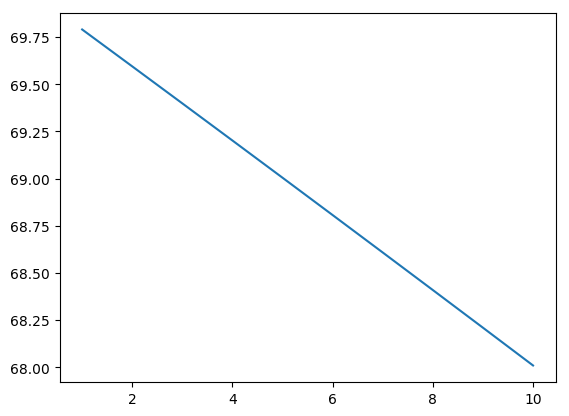

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc0ed3c9550>

In [20]:
plot(x_grid,px[1,:])